----
##Exploratory Data Analysis and Data Visualization of US Baby Names 1880–2018
----

The United States Social Security Administration (SSA) has made available data on the frequency of baby names from 1880 through the present. These plain text data files, one per year, contain the total number of births for each sex/name combination. The raw archive of these files can be obtained from http://www.ssa.gov/oact/babynames/limits.html.

After downloading the 'National data' file names.zip and unzipping it, you will have a directory containing a series of files like yob1880.txt through yob2018.txt. We need to do some data wrangling to load this dataset (see code below).





### Goal

In this project I aim to show competence with the Python data science stack (Numpy, Pandas, Matplotlib, Seaborn) and experience manipulating, summarizing, and visualing datasets.

Lastly we will explore how the names with "Sam" vary in frequency between genders over time.


---------
## Imports + Google Drive

In [47]:
# Imports
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', palette='Set2')
from scipy.stats import pearsonr
import urllib.request as urllib2
from zipfile import ZipFile
from io import BytesIO
import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import sys                      # system module, used to get Python version 
import datetime as dt           # date tools, used to note current date  

print('\nPython version: ', sys.version) 
print('Pandas version: ', pd.__version__)
print('Requests version: ', requests.__version__)
print("Today's date:", dt.date.today())




Python version:  3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Pandas version:  1.3.5
Requests version:  2.23.0
Today's date: 2022-06-22


In [48]:
r = urllib2.urlopen("https://github.com/Aweesam/data-files/raw/main/names.zip").read()
file = ZipFile(BytesIO(r))

years = range(1880, 2019)

pieces = []
columns = ['name', 'sex', 'births']

for year in years:
    path = 'yob%d.txt' % year
    file_path = file.open(path)
    frame = pd.read_csv(file_path, names=columns)

    frame['year'] = year
    pieces.append(frame)

# Concatenate everything into a single DataFrame
names = pd.concat(pieces, ignore_index=True)

In [49]:
names

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
...,...,...,...,...
1957041,Zylas,M,5,2018
1957042,Zyran,M,5,2018
1957043,Zyrie,M,5,2018
1957044,Zyron,M,5,2018


### Number of baby boys and baby girls born each year.



In [50]:
names_piv = names.pivot_table( values='births', index='sex', columns='year', aggfunc=np.sum , margins=True)
names_piv

year,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,All
sex,,,,,,,,,,,,,,,,,,,,,
F,90994,91953,107847,112319,129019,133055,144533,145981,178622,178366,...,1775345,1756592,1758171,1751320,1782350,1780453,1766212,1719138,1686961,174079232
M,110490,100743,113686,104625,114442,107799,110785,101412,120851,110580,...,1916476,1896574,1893975,1888009,1916564,1911537,1891585,1842837,1800392,177573793
All,201484,192696,221533,216944,243461,240854,255318,247393,299473,288946,...,3691821,3653166,3652146,3639329,3698914,3691990,3657797,3561975,3487353,351653025


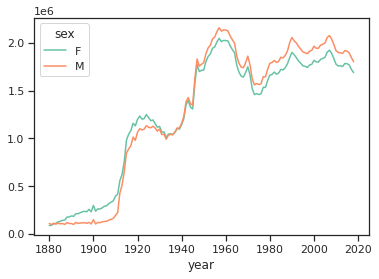

In [51]:
names_piv2 = names.pivot_table( 'births', index='year', columns='sex', aggfunc='sum' , margins=False).plot()
names_piv2

-------------
### Analyzing Naming Trends

Suppose we're interested in analyzing the Top 1000 most popular baby names per year.

We will do so by following these steps:
1. Insert a column _prop_ with the fraction of babies given each name relative to the total number of births. A prop value of 0.02 would indicate that 2 out of every 100 babies were given a particular name in a given year. 
2. Group the data by year and sex, then add the new column to each group.
3. Extract a subset of the data (the top 1,000 names for each sex/year combination). This is yet another group operation.
4. Split the Top 1,000 names into the boy and girl portions.
5. Build a pivot table of the total number of births by year and name.

Finally, we will plot the percentage of babies named 'John', 'Noah', 'Madison', or 'Lorraine' over time.

In [52]:
def add_prop(group):
    group['prop'] = group.births / group.births.sum()
    return group
names = names.groupby(['year', 'sex']).apply(add_prop)

In [53]:
names

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077642
1,Anna,F,2604,1880,0.028617
2,Emma,F,2003,1880,0.022012
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
1957041,Zylas,M,5,2018,0.000003
1957042,Zyran,M,5,2018,0.000003
1957043,Zyrie,M,5,2018,0.000003
1957044,Zyron,M,5,2018,0.000003


In [54]:
# Sanity check (all percentages should add up to 1, i.e., 100%)
names.groupby(['year', 'sex']).prop.sum()

year  sex
1880  F      1.0
      M      1.0
1881  F      1.0
      M      1.0
1882  F      1.0
            ... 
2016  M      1.0
2017  F      1.0
      M      1.0
2018  F      1.0
      M      1.0
Name: prop, Length: 278, dtype: float64

In [55]:
def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]
grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)
# Drop the group index, not needed
top1000.reset_index(inplace=True, drop=True)

In [56]:
top1000

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077642
1,Anna,F,2604,1880,0.028617
2,Emma,F,2003,1880,0.022012
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
277872,Korbyn,M,207,2018,0.000115
277873,Randall,M,207,2018,0.000115
277874,Benton,M,206,2018,0.000114
277875,Coleman,M,206,2018,0.000114


In [57]:
boys = top1000[top1000.sex == 'M']
girls = top1000[top1000.sex == 'F']

In [58]:
total_births = top1000.pivot_table('births', index='year',
                                   columns='name',
                                   aggfunc=sum)

In [59]:
total_births.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 1880 to 2018
Columns: 7174 entries, Aaden to Zyaire
dtypes: float64(7174)
memory usage: 7.6 MB


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f90e7e3d110>,
      dtype=object)

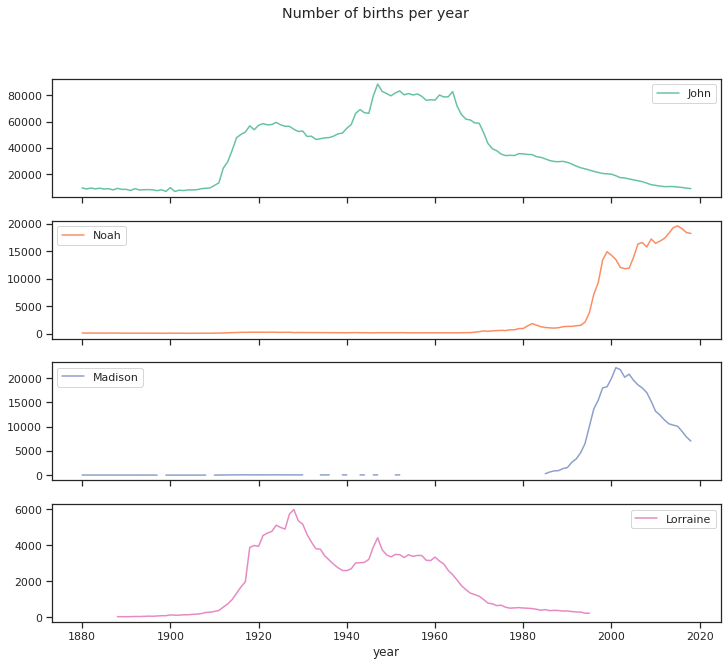

In [60]:
subset = total_births[['John', 'Noah', 'Madison', 'Lorraine']]
subset.plot(subplots=True, figsize=(12, 10), grid=False,
            title="Number of births per year")

-------------
### Boy names that became girl names (and vice versa)

Next, let's look at baby names that were more popular with one sex earlier in the sample but have switched to the opposite sex over the years. One example is the name Lesley or Leslie (or other possible, less common, spelling variations). 

We will do so by following these steps:
1. Go back to the top1000 DataFrame and compute a list of names occurring in the dataset starting with “lesl”.
2. Filter down to just those names and sum births grouped by name to see the relative frequencies.
3. Aggregate by sex and year and normalize within year.
4. Plot the breakdown by sex over time.

In [61]:
all_names = pd.Series(top1000.name.unique())
lesley_like = all_names[all_names.str.lower().str.contains('lesl')]
lesley_like

632     Leslie
2294    Lesley
4264    Leslee
4732     Lesli
6108     Lesly
dtype: object

In [62]:
filtered = top1000[top1000.name.isin(lesley_like)]
filtered.groupby('name').births.sum()

name
Leslee       993
Lesley     35033
Lesli        929
Leslie    378168
Lesly      11433
Name: births, dtype: int64

In [63]:
table = filtered.pivot_table('births', index='year',
                             columns='sex', aggfunc='sum')
table = table.div(table.sum(1), axis=0)

<Figure size 432x288 with 0 Axes>

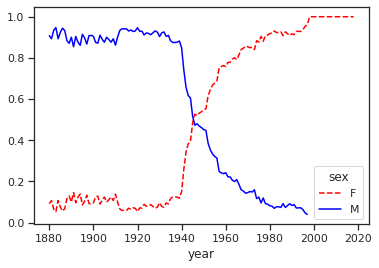

In [64]:
fig = plt.figure()
table.plot(style={'M': 'b-', 'F': 'r--'})

### Hypothesis: A name with "sam" in it i.e: samuel, sammy, samantha, sam, samson occurs more commonly with boys

In [65]:
#Code to test hypothesis

def get_all(group):
  return group.sort_values(by='births', ascending=False)[:]

grouped = names.groupby(['year','sex'])
top_all = grouped.apply(get_all)
top_all.reset_index(inplace=True,drop=True)

In [66]:
boys_all = top_all[top_all.sex == 'M']
girls_all = top_all[top_all.sex == 'F']

total_births = top_all.pivot_table('births', index='year', columns='name',aggfunc=sum)


In [67]:
top_all

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077642
1,Anna,F,2604,1880,0.028617
2,Emma,F,2003,1880,0.022012
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
1957041,Gaylon,M,5,2018,0.000003
1957042,Gavynn,M,5,2018,0.000003
1957043,Gavon,M,5,2018,0.000003
1957044,Gaurav,M,5,2018,0.000003


In [68]:
all_the_names = pd.Series(top_all.name.unique())

#now get the filter the list of unique names to only that have 'sam' in it.
#aka, the name is "sam-like"
sam_like = all_the_names[all_the_names.str.lower().str.contains('sam')]
sam_like

355      Samantha
774        Sammie
944        Samuel
958           Sam
1769         Isam
           ...   
97207       Samip
97208       Samim
97209      Sameep
97767    Samairah
98232     Samaksh
Length: 355, dtype: object

In [69]:
#Now, with top_all containing the percentage/count of babies born with
#a certain name per year, we can filter that list by matching it again
#the series of sam-like names.

filter_sam = top_all[top_all.name.isin(sam_like)]
filter_sam.groupby('name').births.sum()

#here you can see we now have a table of sam-like names with the number
#of births per year, per gender, along with the probability of that instance.
filter_sam.head()

,name,sex,births,year,prop
355,Samantha,F,21,1880,0.000231
774,Sammie,F,6,1880,0.000066
958,Samuel,M,1024,1880,0.009268
977,Sam,M,457,1880,0.004136
1791,Sammie,M,6,1880,0.000054


In [70]:
#Since we just want to compare sam-like in male vs females, we can use the aggregate function
#and tell it to use the sum.

table_sam = filter_sam.pivot_table('births', index='year', columns='sex', aggfunc='sum')
table_sam

sex,F,M
year,,
1880,27,1502
1881,26,1416
1882,20,1593
1883,26,1425
1884,27,1498
...,...,...
2014,8511,13335
2015,8091,13255
2016,7939,12927


<Figure size 432x288 with 0 Axes>

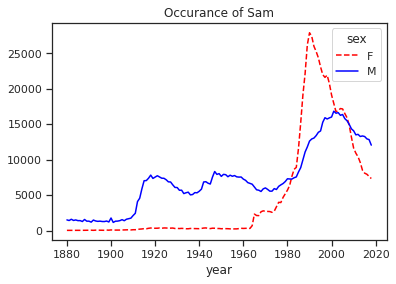

In [77]:
#now we can plot the table above to nicely see what gender had more
#sam-like names
fig = plt.figure()
table_sam.plot(style={'M': 'b-', 'F': 'r--'}, title='Occurance of Sam')

### Conclusion:

Having "sam" inside your name was much more common for boys for most of history, until 1980 where having "sam" in a girls name become much more common.